In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
import time
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
import matplotlib.gridspec as gridspec
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report

In [2]:
full_data = pd.read_csv('weatherAUS.csv')
full_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


## Exploração dos dados

Iremos checar primeiro o numero de linhas e colunas. Posteriormente, iremos checar o tamanho do conjunto de dados para decidir se é necessário a compressao de tamanho.

In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

RainToday e RainTomorrow sao objetos (Sim/Nao). Iremos convertê-los para formato binario (1/0), para nossa conveniencia.

In [4]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1}, inplace= True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace= True)

Agora, iremos checar se o conjunto de dados está balanceado ou desbalanceado. Se os dados estiverem desbalanceados, iremos precisar fazer um downsample da maioria ou um oversample da minoria para balancear os dados.

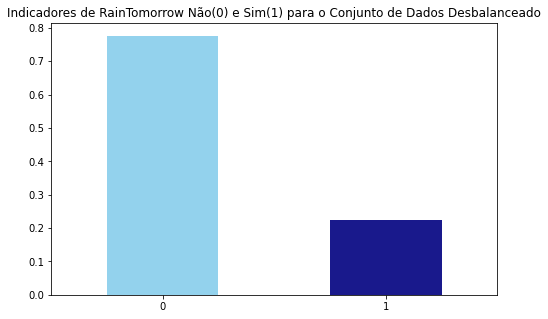

In [5]:
fig = plt.figure(figsize= (8, 5))
full_data.RainTomorrow.value_counts(normalize= True).plot(kind= 'bar', color= ['skyblue', 'navy'], alpha= 0.9, rot= 0)
plt.title('Indicadores de RainTomorrow Não(0) e Sim(1) para o Conjunto de Dados Desbalanceado')
plt.show()

`value_counts(normalize)` nos mostra a frequência relativa de RainTomorrow no conjunto de dados

In [6]:
full_data.RainTomorrow.value_counts(normalize=True)

0    0.775819
1    0.224181
Name: RainTomorrow, dtype: float64

Podemos notar um desbalanceamento de classe. Para tratarmos esse problema iremos usar o método de oversampling da classe de minoria. Já que o tamanho do conjunto de dados é pequeno, o subsampling da classe de maioria nao faria muito sentido neste caso.

## Lidando com desbalanceamento de classe para predição de chuva

In [7]:
no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace= True, n_samples= len(no), random_state= 123)
oversampled = pd.concat([no, yes_oversampled])

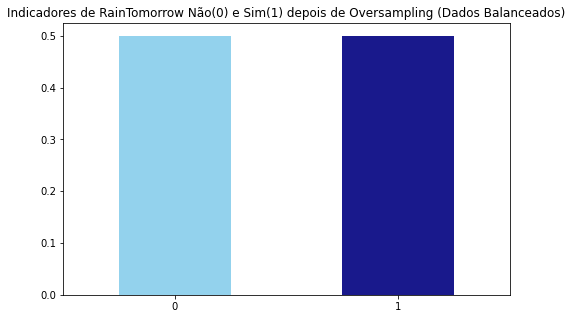

In [8]:
fig = plt.figure(figsize = (8, 5))
oversampled.RainTomorrow.value_counts(normalize= True).plot(kind='bar', color= ['skyblue', 'navy'], alpha= 0.9, rot= 0)
plt.title('Indicadores de RainTomorrow Não(0) e Sim(1) depois de Oversampling (Dados Balanceados)')
plt.show()

In [9]:
oversampled.RainTomorrow.value_counts(normalize= True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

Checar os dados faltantes para o modelo no conjunto de dados

<AxesSubplot:>

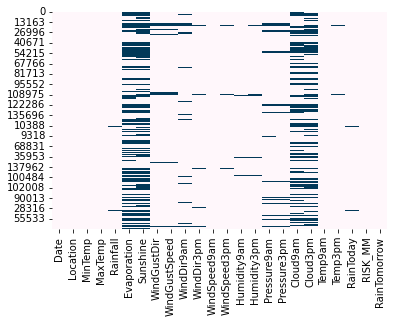

In [10]:
# Padrão de dados faltantes nos dados de treinamento do modelo
sns.heatmap(oversampled.isnull(), cbar= False, cmap= 'PuBu')

Obiviamente, "Evaporação, Sunshine, Cloud9am e Cloud3pm" são os fatores com uma alta frequencia de dados faltantes. Checaremos os detalhes destes dados para esses 4 fatores.

In [11]:
total = oversampled.isnull().sum().sort_values(ascending= False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending = False)
missing = pd.concat([total, percent], axis= 1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


Podemos observar que os 4 fatores tem menos que 50% de dados faltantes. Então, ao invés de rejeitarmos eles completamente, iremos considerá-los em nosso modelo com a correta imputação

## Imputação e transformação

Iremos imputar as colunas categoricas com mode, e entao usaremos o encoder de label para converter em numeros. Assim que todas as colunas no dataframe estiverem convertidas para colunas numericas, iremos imputar os valores faltantes utilizando Multiple Imputation por Chained Equations pacote (MICE).

Então, iremos detectar os outliers utilizando o range de interquartiles e remove-los para obter o dataset de trabalho final. Finalmente, iremos checar a correlação entre as diferentes variaveis, e se acharmos um par de variaveis altamente correlacionaveis, iremos descartar uma, enquanto mantemos a outra.

In [12]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

`mode()` retorna o valore que aparece com mais frequencia para o conjunto de dados

In [13]:
# Imputar var categorico com Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [14]:
# Converter fatores categoricos para continuos com Label Encoding
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [15]:
warnings.filterwarnings('ignore')

# Imputação multipla por Chained Equations

MiceImputed = oversampled.copy(deep= True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

O dataframe nao possuim NaN valores. Nao iremos detectar, nem eliminar outliers do intervalo de inter-quartile do conjunto de dados

In [16]:
# Detectando outliers com IQR

Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.119679
Sunshine            5.947404
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.681346
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


In [17]:
# Removendo outliers do conjunto de dados
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) | (MiceImputed > (Q3 + 1.5 * IQR))).any(axis= 1)]
MiceImputed.shape

(156852, 24)

Iremos checar a multicolinearidade, que significa o quanto uma caracteristica está correlacionada com outra.

<AxesSubplot:>

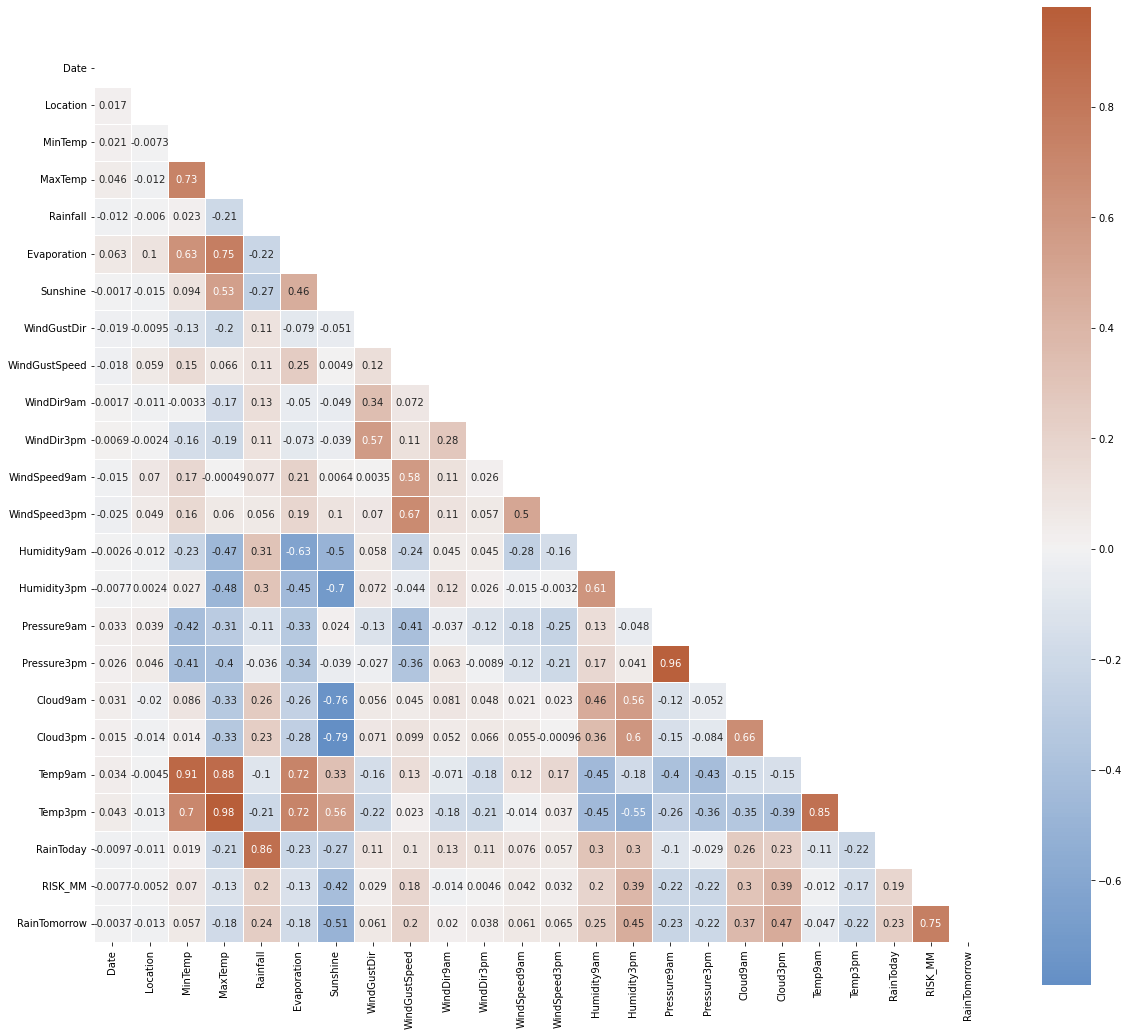

In [18]:
# Heatmap de correlação
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype= np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap= True)
sns.heatmap(corr, mask= mask, cmap= cmap, vmax=None, center=0, square= True, annot= True, linewidths=.5, cbar_kws={'shrink': .9})

Os fatores que apresentam forte correlação entre eles são:

* MaxTemp e MinTemp
* Pressure9h e pressure3h
* Temp9am e Temp3pm
* Evaporation e MaxTemp
* MaxTemp e Temp3pm, mas em nenhum caso a correlação será perfeitamente 1.

Podemos aprofundar um pouco mais na correlação destes fatores examinando os pares de diagramas. Cada um dos pares de plots mostram um cluster claro e distinto de RanTomorrow sim e nao. Existe um overlap minimo entre eles.

In [19]:
# sns.pairplot( data=tt, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )
# tt = MiceImputed - MiceImputed[MiceImputed.index.duplicated()]

## Seleção de fator para predição de chuva

Utilizaremos tanto o metodo dos filtros (valor de qui quadrado) e o metodos wrapper para selecionar os fatores de treinamento para predição do modelo.

Pelo metodo do qui quadrado, primeiro temos que normalizar os dados. Utilizaremos MinMaxScaler ao inves de StardardScaler, para previnir valores negativos.

In [20]:
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [21]:
# Fatores de importancia usando metodo dos filtros (Qui Quadrado)

X = modified_data.loc[:,modified_data.columns != 'RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RISK_MM'],
      dtype='object')


Podemos observar que 'Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', tem uma maior importancia quando comparadas a outros fatores.

Seleção de fatores pelo metodo wrapping (random forest).

In [22]:
X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Cloud3pm', 'RISK_MM']
[0.00205993 0.00215407 0.00259089 0.00367568 0.0102656  0.00252838
 0.05894157 0.00143001 0.00797518 0.00177178 0.00167654 0.0014278
 0.00187743 0.00760691 0.03091966 0.00830365 0.01193018 0.02113544
 0.04962418 0.00270103 0.00513723 0.00352198 0.76074491]


## Treinando o modelo de predição de chuva com diferentes modelos

Iremos dividir o conjunto de dados em treinamento (75%) e teste (25%) para o modelo de predição. Para melhores resultados, iremos padronizar nosso X_train e X_test:

In [23]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Dividir entre test e train
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [24]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [25]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.7896105883253003
ROC Area under Curve = 0.7697608124186093
Cohen's Kappa = 0.5494133526754494
Time taken = 1.2752840518951416
              precision    recall  f1-score   support

         0.0    0.80824   0.85940   0.83304     23948
         1.0    0.75511   0.68012   0.71565     15265

    accuracy                        0.78961     39213
   macro avg    0.78167   0.76976   0.77435     39213
weighted avg    0.78756   0.78961   0.78734     39213



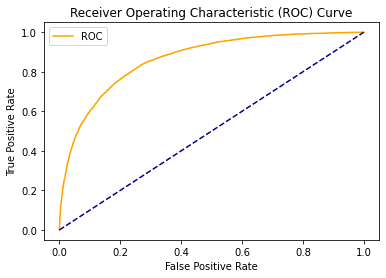

Accuracy = 0.8583122943921658
ROC Area under Curve = 0.854724083915631
Cohen's Kappa = 0.704212742623119
Time taken = 0.4280972480773926
              precision    recall  f1-score   support

         0.0    0.89431   0.87093   0.88246     23948
         1.0    0.80549   0.83852   0.82167     15265

    accuracy                        0.85831     39213
   macro avg    0.84990   0.85472   0.85207     39213
weighted avg    0.85973   0.85831   0.85880     39213



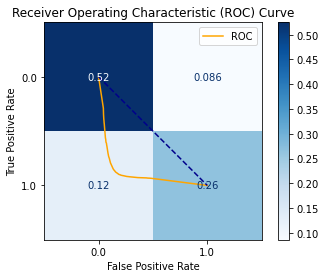

Accuracy = 0.8867977456455767
ROC Area under Curve = 0.8812163648490279
Cohen's Kappa = 0.7620435752411092
Time taken = 192.4504997730255
              precision    recall  f1-score   support

         0.0    0.90805   0.90642   0.90724     23948
         1.0    0.85361   0.85601   0.85481     15265

    accuracy                        0.88680     39213
   macro avg    0.88083   0.88122   0.88102     39213
weighted avg    0.88686   0.88680   0.88683     39213



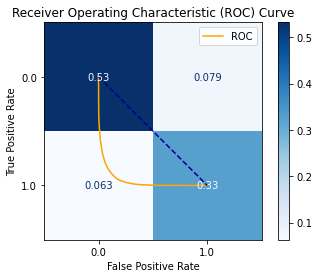

Accuracy = 0.9280595720806876
ROC Area under Curve = 0.9265770863620824
Cohen's Kappa = 0.8493714659078331
Time taken = 26.023707628250122
              precision    recall  f1-score   support

         0.0    0.94812   0.93327   0.94064     23948
         1.0    0.89783   0.91988   0.90872     15265

    accuracy                        0.92806     39213
   macro avg    0.92297   0.92658   0.92468     39213
weighted avg    0.92854   0.92806   0.92821     39213



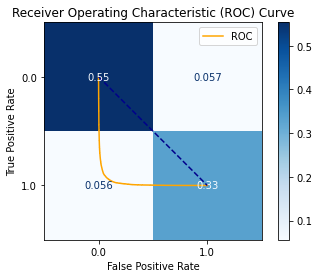

Accuracy = 0.8684619896462907
ROC Area under Curve = 0.860694163700355
Cohen's Kappa = 0.7228133047900757
Time taken = 1.8774261474609375
              precision    recall  f1-score   support

         0.0    0.88961   0.89577   0.89268     23948
         1.0    0.83469   0.82561   0.83013     15265

    accuracy                        0.86846     39213
   macro avg    0.86215   0.86069   0.86140     39213
weighted avg    0.86823   0.86846   0.86833     39213



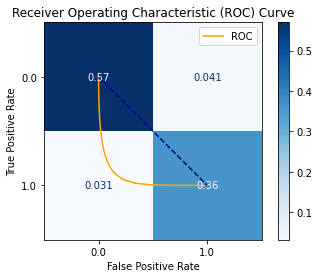

Accuracy = 0.9418560171371739
ROC Area under Curve = 0.9449267946584342
Cohen's Kappa = 0.8791826232502136
Time taken = 214.81439399719238
              precision    recall  f1-score   support

         0.0    0.97256   0.93106   0.95136     23948
         1.0    0.89863   0.95879   0.92774     15265

    accuracy                        0.94186     39213
   macro avg    0.93560   0.94493   0.93955     39213
weighted avg    0.94378   0.94186   0.94216     39213



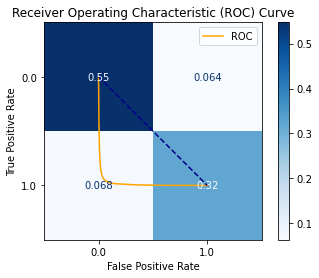

[18:11:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 0.9563665111060108
ROC Area under Curve = 0.9565810552736519
Cohen's Kappa = 0.908683590430594
Time taken = 72.3363151550293
              precision    recall  f1-score   support

         0.0    0.97246   0.95561   0.96396     23948
         1.0    0.93221   0.95755   0.94471     15265

    accuracy                        0.95637     39213
   macro avg    0.95234   0.95658   0.95434     39213
weighted avg    0.95679   0.95637   0.95647     39213



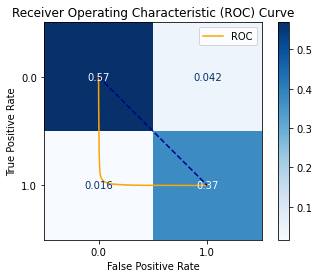

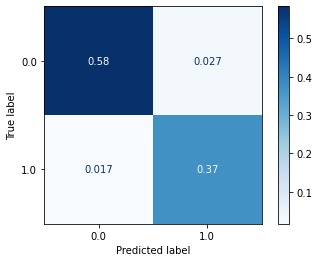

In [26]:
# Logistic Regression
params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

# Decision Tree
params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

# Neural Network
params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

# Random Forest
params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

# Light GBM
params_lgb ={'colsample_bytree': 0.95, 
         'max_depth': 16, 
         'min_split_gain': 0.1, 
         'n_estimators': 200, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

# Catboost
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

# XGBoost
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[18:15:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[18:15:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


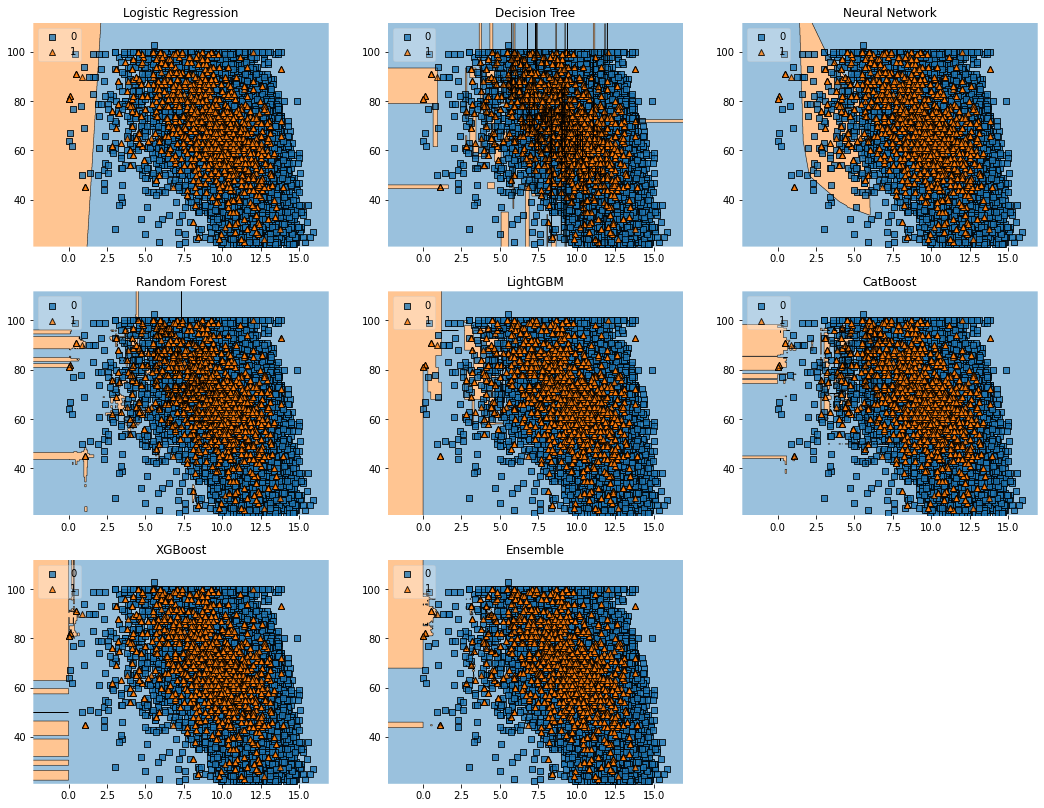

In [27]:
value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345) 
clf3 = MLPClassifier(random_state=12345, verbose = 0)
clf4 = rf(random_state=12345)
clf5 = lgb.LGBMClassifier(random_state=12345, verbose = 0)
clf6 = cb.CatBoostClassifier(random_state=12345, verbose = 0)
clf7 = xgb.XGBClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf4, clf5, clf6, clf7], weights=[1, 1, 1, 1], voting='soft')

X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]] #took only really important features
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Neural Network',
          'Random Forest',
          'LightGBM',
          'CatBoost',
          'XGBoost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, 
                                filler_feature_values={2: value}, 
                                filler_feature_ranges={2: width}, 
                                legend=2)
    plt.title(lab)

plt.show()

Podemos observar as diferenças de limite de classe para os diferentes modelos. O CatBoost tem uma borda regional distinta quando comparado com os outros modelos. No entando, XGBoost e o Random Forest tambem tem um menor numero de dados mau classificados quando comparados a outros modelos

## Comparação de modelos de predição de chuva

Agora temos que decidir qual modelo performou melhor baseado no score de precisao, ROC_AUC, Cohen's Kappa e Total Run Time. Um ponto a se considerar seria o F1-score como a melhor metrica para julgamento de performance do modelo ao inves da acurácia, mas como ja convertemos o conjunto de dados desbalanceado para balanceado, escolher a acuracia para decidir o melhor modelo é justificada neste caso.

Para uma melhor decisao, escolheremos o Cohen's Kappa, que na verdade é a escolha ideal de metrica para decidir o melhor modelo em casos de conjunto de dados desbalanceados. 

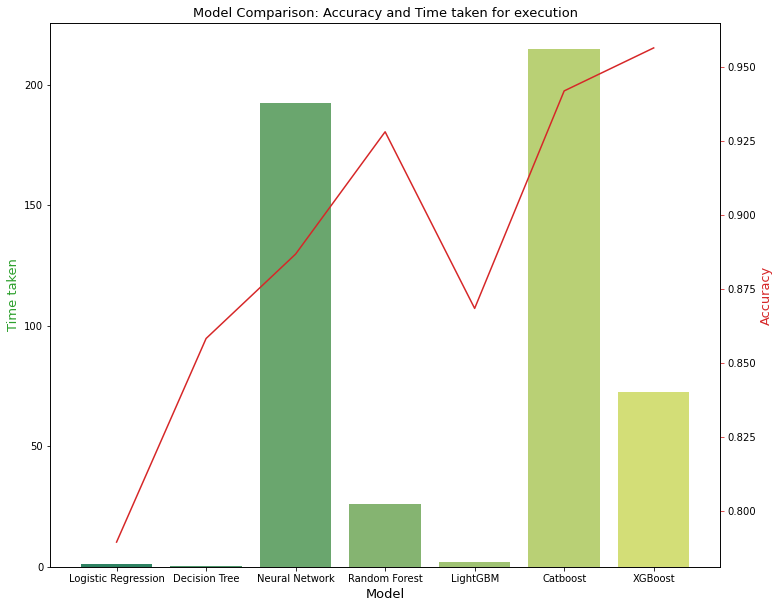

In [28]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_lgb, accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_lgb, coh_kap_cb, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_lgb, tt_cb, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

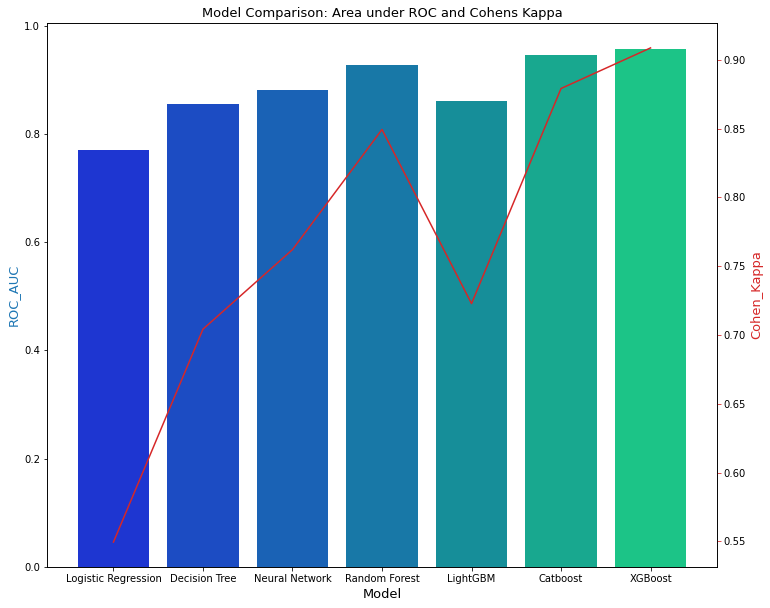

In [29]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()

Podemos observar que o XGBoost, CatBoost e o Random Forest performaram melhor quando comparados a outros modelos. Entretanto, se a velocidade é importante para se considerar, podemos escolher com o modelo Random Forest ao inves do XGBoost ou CatBoost.

In [30]:
!jupyter nbconvert  Estimador_chuva.ipynb --to html

[NbConvertApp] Converting notebook Estimador_chuva.ipynb to html
[NbConvertApp] Writing 1109259 bytes to Estimador_chuva.html
